In [2]:
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import emoji
import unicodedata
from unidecode import unidecode
from colorama import Fore, Style
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize


plt.style.use('Solarize_Light2')
# Download NLTK resources if not already installed
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Main\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### ~~~~~~ Functions ~~~~~~~~ ###

In [4]:
# Function to load JSON data from a file
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

# Function to extract messages from the JSON data
def extract_messages(data):
    messages = data.get('messages', [])
    return messages

# Function to convert the JSON data into a Pandas DataFrame
def text_to_emoji(text):
    return text.encode('latin1').decode('utf-8')

# Function to fix encoding issues
def fix_encoding(text):
    if isinstance(text, str):
        try:
            # Try UTF-8 decoding first
            return text.encode('latin1').decode('utf-8')
        except UnicodeEncodeError:
            try:
                # If it fails, try the next encoding
                return text.encode('iso-8859-1').decode('utf-8')
            except UnicodeEncodeError:
                # If both fail, return the original text
                return text
    else:
        return text

# Function to correct encoding
def correct_encoding(text):
    try:
        return text.encode('latin1').decode('utf-8')
    except Exception as e:
        # Return the original text if there's an error
        return text

# Function to check if text contains non-Latin characters
def contains_non_latin(text):
    return re.search(r'[^\p{Latin}\p{Common}]', text) is not None

# Function to normalize text
def normalize_text(text):
    try:
        if not contains_non_latin(text):
            return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
        else:
            return text
    except Exception as e:
        # Return the original text if there's an error
        return text

# Function to check if 'share' contains a link with 'reel'
def contains_reel_link(share_data):
    if isinstance(share_data, dict) and 'link' in share_data:
        return 1 if 'reel' in share_data['link'] else 0
    return 0


### ~~~~~~~ Code ~~~~~~~~~ 

In [5]:
# Specify the root directory where all user folders are located
root_directory = './inbox/'

# Drop rows where the user is "baitalmandifc", "csit", or "alshamigroup"
users_to_drop = ["baitalmandifc", "csit", "alshamigroup", "whatisthememeingoflife"]

# Specify the columns to drop
columns_to_drop = ['call_duration', 'sticker', 'is_geoblocked_for_viewer']

your_instagram_name = 'Adam'

In [6]:
# Initialize an empty DataFrame to store all messages
all_messages_df = pd.DataFrame()

# Iterate through user folders
for user_folder in os.listdir(root_directory):
    user_folder_path = os.path.join(root_directory, user_folder)
    
    # Check if the item in the directory is a folder
    if os.path.isdir(user_folder_path):
        
        # Iterate through JSON files in the user's folder
        for json_file in os.listdir(user_folder_path):
            if json_file.endswith('.json'):
                json_file_path = os.path.join(user_folder_path, json_file)
                
                # Load JSON data
                data = load_json(json_file_path)
                
                # Extract messages
                messages = extract_messages(data)
                
                # Create a Pandas DataFrame from the messages
                df = pd.DataFrame(messages)
                
                # Add a column for the user's name
                df['user'] = user_folder.rsplit('_', 1)[0]
                
                # Concatenate the DataFrame to the overall DataFrame
                all_messages_df = pd.concat([all_messages_df, df])

# Drop the specified columns
all_messages_df = all_messages_df.drop(columns=columns_to_drop, errors='ignore')

# Drop rows where 'sender_name' is in the list of users to drop or where 'sender_name' is "Instagram User" or 'user' is "instagramuser"
all_messages_df = all_messages_df[
    ~(all_messages_df['user'].isin(users_to_drop) | 
      (all_messages_df['sender_name'] == "Instagram User") |
      (all_messages_df['user'] == "instagramuser")
      )
]


# Extract only the 'reaction' from the 'reactions' column and use text_to_emoji() to convert it to emoji
all_messages_df['reactions'] = all_messages_df['reactions'].apply(lambda x: x[0]['reaction'].encode('latin1').decode('utf-8') if isinstance(x, list) and len(x) > 0 else None)


# Convert the 'timestamp_ms' column to datetime format
all_messages_df['timestamp'] = pd.to_datetime(all_messages_df['timestamp_ms'], unit='ms')

# Create new columns for year, month, day, and time
all_messages_df['year'] = all_messages_df['timestamp'].dt.year
all_messages_df['month'] = all_messages_df['timestamp'].dt.month
all_messages_df['day'] = all_messages_df['timestamp'].dt.day
all_messages_df['time'] = all_messages_df['timestamp'].dt.strftime('%H:%M')
all_messages_df['hour'] = all_messages_df['timestamp'].dt.hour
all_messages_df['minute'] = all_messages_df['timestamp'].dt.minute


# Regex pattern to match werid characters into readbale text
all_messages_df['sender_name'] = all_messages_df['sender_name'].apply(correct_encoding)

# Apply the function to the 'sender_name' column
all_messages_df['sender_name'] = all_messages_df['sender_name'].apply(normalize_text)

# Apply the fix_encoding function to the 'content' column
all_messages_df['content'] = all_messages_df['content'].apply(fix_encoding)


# Drop rows where 'content' column contains the specified text
all_messages_df = all_messages_df[~all_messages_df['content'].str.contains("تم التفاعل باستخدام", na=False)]
all_messages_df = all_messages_df[~all_messages_df['content'].str.contains("هامت رسالة على الإعجاب", na=False)]

# Apply the function to create the 'Reel' column
all_messages_df['reel'] = all_messages_df['share'].apply(contains_reel_link)

# Create a new column for word count
all_messages_df['word_count'] = all_messages_df['content'].astype(str).apply(lambda x: len(x.split()))


# Display the combined DataFrame
all_messages_df.head()

,sender_name,timestamp_ms,content,reactions,share,user,photos,audio_files,videos,is_unsent,timestamp,year,month,day,time,hour,minute,reel,word_count
0,٠ محمد ٠,1595954650213,Tomorrow 10 pm we have another introductory ca...,None,NaN,0mhmd0,NaN,NaN,NaN,NaN,2020-07-28 16:44:10.213,2020,7,28,16:44,16,44,0,15
1,Adam,1595931588713,Oh okay cool,None,NaN,0mhmd0,NaN,NaN,NaN,NaN,2020-07-28 10:19:48.713,2020,7,28,10:19,10,19,0,3
2,٠ محمد ٠,1595879717507,Also will try to get in @hintofhalal in the ca...,❤️,NaN,0mhmd0,NaN,NaN,NaN,NaN,2020-07-27 19:55:17.507,2020,7,27,19:55,19,55,0,19
3,٠ محمد ٠,1595879227964,Yeah sure ill try to get a introductory call d...,❤️,NaN,0mhmd0,NaN,NaN,NaN,NaN,2020-07-27 19:47:07.964,2020,7,27,19:47,19,47,0,14
4,Adam,1595878304803,I'll look into it a bit more,None,NaN,0mhmd0,NaN,NaN,NaN,NaN,2020-07-27 19:31:44.803,2020,7,27,19:31,19,31,0,7


In [7]:
backup = all_messages_df.copy()
# all_messages_df = backup.copy()

In [8]:
all_messages_df.columns

Index(['sender_name', 'timestamp_ms', 'content', 'reactions', 'share', 'user',
       'photos', 'audio_files', 'videos', 'is_unsent', 'timestamp', 'year',
       'month', 'day', 'time', 'hour', 'minute', 'reel', 'word_count'],
      dtype='object')

# 2023 Review

In [174]:
# Create a new DataFrame for the year 2023
messages_2023_df = all_messages_df[all_messages_df['year'] == 2023]

# Display the new DataFrame
messages_2023_df.sample(10)


,sender_name,timestamp_ms,content,reactions,share,user,photos,audio_files,videos,is_unsent,timestamp,year,month,day,time,hour,minute,reel,word_count
4283,𝐬𝐡𝐢𝐤𝐡𝐚,1689188529648,I’ll break my PR for deadlift,None,NaN,shikha,NaN,NaN,NaN,NaN,2023-07-12 19:02:09.648,2023,7,12,19:02,19,2,0,6
6790,Adam,1700494492297,And when I do this to other girls they ask me ...,None,NaN,shikha,NaN,NaN,NaN,NaN,2023-11-20 15:34:52.297,2023,11,20,15:34,15,34,0,24
7467,Aina ☆,1679394635131,Yes I’m here,None,NaN,aina,NaN,NaN,NaN,NaN,2023-03-21 10:30:35.131,2023,3,21,10:30,10,30,0,3
5806,Adam,1679871749835,then what,None,NaN,emanmulla,NaN,NaN,NaN,NaN,2023-03-26 23:02:29.835,2023,3,26,23:02,23,2,0,2
9183,Adam,1687631820477,😭,None,NaN,shikha,NaN,NaN,NaN,NaN,2023-06-24 18:37:00.477,2023,6,24,18:37,18,37,0,1
160,Adam,1694579008085,Why me,None,NaN,shikha,NaN,NaN,NaN,NaN,2023-09-13 04:23:28.085,2023,9,13,04:23,4,23,0,2
5923,Aina ☆,1691858669514,Trueee,🌸,NaN,aina,NaN,NaN,NaN,NaN,2023-08-12 16:44:29.514,2023,8,12,16:44,16,44,0,1
8580,𝐬𝐡𝐢𝐤𝐡𝐚,1699433778856,my friend said that the girl in this reminded ...,None,NaN,shikha,NaN,NaN,NaN,NaN,2023-11-08 08:56:18.856,2023,11,8,08:56,8,56,0,12
4522,Adam,1680919516809,NaN,None,NaN,emanmulla,NaN,NaN,NaN,NaN,2023-04-08 02:05:16.809,2023,4,8,02:05,2,5,0,1
6899,Eman Mulla,1677785779269,It’s pubh 7,None,NaN,emanmulla,NaN,NaN,NaN,NaN,2023-03-02 19:36:19.269,2023,3,2,19:36,19,36,0,3


In [14]:
# See the number of messages sent by each user
message_count_by_user = messages_2023_df['sender_name'].value_counts()
print(message_count_by_user[0:10])

sender_name
Adam           49965
𝐬𝐡𝐢𝐤𝐡𝐚         32373
Eman Mulla     22617
Aina ☆          3534
W               2832
Youxxef8        2041
jeremyn <33      645
ejazz            336
Maya             245
mehna            241
Name: count, dtype: int64


In [23]:
plt.style.use('Solarize_Light2')

d:\Instagram Data\instagram-uhdammm-2023-12-28-nNBHQNRW\your_instagram_activity\insta\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 119852 (\N{MATHEMATICAL BOLD SMALL S}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Instagram Data\instagram-uhdammm-2023-12-28-nNBHQNRW\your_instagram_activity\insta\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 119841 (\N{MATHEMATICAL BOLD SMALL H}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Instagram Data\instagram-uhdammm-2023-12-28-nNBHQNRW\your_instagram_activity\insta\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 119842 (\N{MATHEMATICAL BOLD SMALL I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Instagram Data\instagram-uhdammm-2023-12-28-nNBHQNRW\your_instagram_activity\insta\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 119844 (\N{MATHEMATICAL BOLD SMALL K}) missing from curr

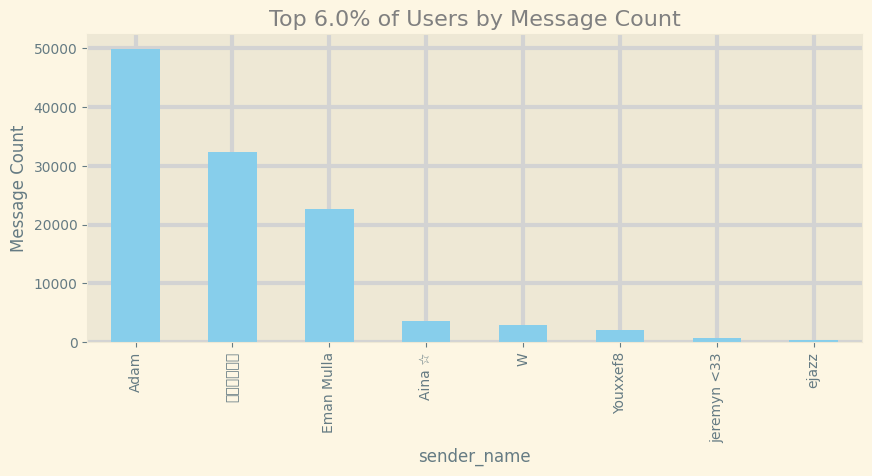

In [170]:
# percentage to calculate
percentage = 0.06
col_name = 'sender_name'

# Recalculate the message count for each user
user_message_counts = messages_2023_df[col_name].value_counts()

# Select the top 10% of users
top_users = user_message_counts.head(int(len(user_message_counts) * percentage))

# Filter the DataFrame to include only messages from the top users
top_users_messages = messages_2023_df[messages_2023_df[col_name].isin(top_users.index)]

# Visualize the number of messages from the top users
plt.figure(figsize=(10, 4))
top_users.plot(kind='bar', color='skyblue')
title = f'Top {percentage * 100}% of Users by Message Count'

# Change the grid line color
plt.grid(True, color='lightgray', linestyle='-', linewidth=3)

plt.title(title, color='gray')
plt.xlabel(col_name)
plt.ylabel('Message Count')
plt.show()


## Activity Over Time

In [69]:
# Separate messages sent by '[your_instagram_name]' and by others
your_messages = messages_2023_df[messages_2023_df['sender_name'] == your_instagram_name]
other_messages = messages_2023_df[messages_2023_df['sender_name'] != your_instagram_name]

### Monthly Message Activity in 2023

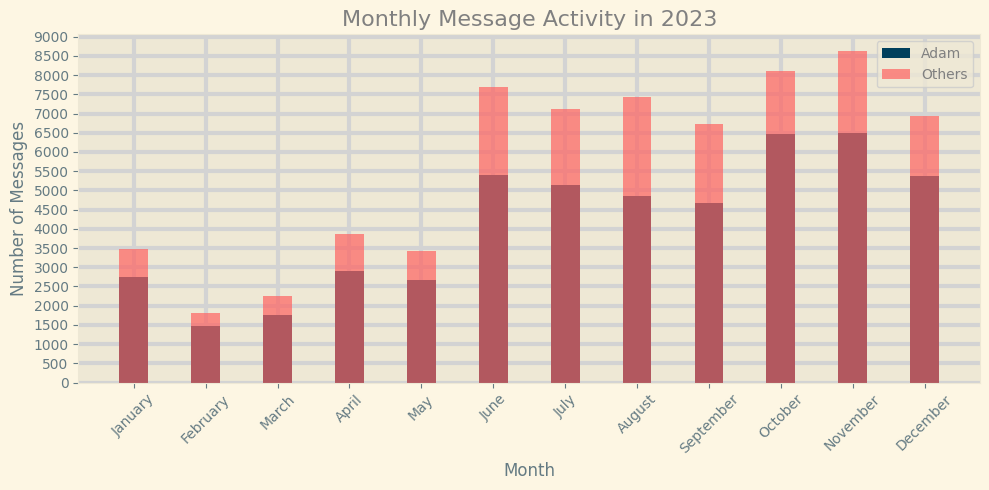

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

your_messages = your_messages.copy()
your_messages.reset_index(inplace=True)
your_messages['timestamp_ms'] = pd.to_datetime(your_messages['timestamp_ms'], unit='ms')
your_messages.set_index('timestamp_ms', inplace=True)

other_messages = other_messages.copy()
other_messages.reset_index(inplace=True)
other_messages['timestamp_ms'] = pd.to_datetime(other_messages['timestamp_ms'], unit='ms')
other_messages.set_index('timestamp_ms', inplace=True)

# Resample and count messages per month for both you and others
your_monthly_messages = your_messages.resample('M').size()
other_monthly_messages = other_messages.resample('M').size()

# Plotting
plt.figure(figsize=(10, 5))

# Get month names for x-axis labels
months = [d.strftime('%B') for d in your_monthly_messages.index]

# Total messages by You
plt.bar(months, your_monthly_messages, color='#003f5c', label=your_instagram_name, width=0.4)
# Total messages by Others
plt.bar(months, other_monthly_messages, color='#ff6361', label='Others', width=0.4, alpha=0.7)

plt.title('Monthly Message Activity in 2023', color='gray')
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)

# Set y-axis values with 500 intervals
max_y_value = max(your_monthly_messages.max(), other_monthly_messages.max())
y_tick_interval = 500
y_ticks = range(0, max_y_value + y_tick_interval, y_tick_interval)
plt.yticks(y_ticks)

# Change the grid line color
plt.grid(True, color='lightgray', linestyle='-', linewidth=3)

for text in plt.legend().get_texts():
    text.set_color('grey')

plt.grid(True)
plt.tight_layout()
plt.show()


### Monthly Message Activity in 2023

In [131]:
# Assuming 'timestamp_ms' is the column containing timestamps in milliseconds
your_messages = your_messages.copy()
your_messages.reset_index(inplace=True)
your_messages['timestamp_ms'] = pd.to_datetime(your_messages['timestamp_ms'], unit='ms')
your_messages.set_index('timestamp_ms', inplace=True)

# Assuming 'timestamp_ms' is also the column containing timestamps for others' messages
other_messages = other_messages.copy()
other_messages.reset_index(inplace=True)
other_messages['timestamp_ms'] = pd.to_datetime(other_messages['timestamp_ms'], unit='ms')
other_messages.set_index('timestamp_ms', inplace=True)

# Resample and count messages per month for both you and others
your_monthly_messages = your_messages.resample('M').size()
other_monthly_messages = other_messages.resample('M').size()

# Display the results with aligned bars
print("Monthly Message Activity in 2023\n")

# Get month names for x-axis labels
months = [d.strftime('%B') for d in your_monthly_messages.index]

# Determine the length of the longest month name for alignment
max_month_length = max(len(month) for month in months)

# Display total messages for both you and others
for month, your_count, other_count in zip(months, your_monthly_messages, other_monthly_messages):
    # Calculate the scale factor for each category separately
    max_count_your = max(your_monthly_messages) if not your_monthly_messages.empty else 1
    max_count_others = max(other_monthly_messages) if not other_monthly_messages.empty else 1
    scale_factor_your = 50 / max_count_your
    scale_factor_others = 50 / max_count_others

    # Calculate bar lengths for both categories
    bar_length_your = int(your_count * scale_factor_your)
    bar_length_others = int(other_count * scale_factor_others)

    # Pad the month name for alignment
    padded_month = month.ljust(max_month_length + 1)

    # Display the results
    print(f"Your   {padded_month} ({your_count}):\t{Fore.CYAN}{'█' * bar_length_your}{Style.RESET_ALL}")
    print(f"Others {padded_month} ({other_count}):\t{Fore.BLUE}{'█' * bar_length_others}{Style.RESET_ALL}")


Monthly Message Activity in 2023

Your   January    (2755):	█████████████████████
Others January    (3464):	████████████████████
Your   February   (1473):	███████████
Others February   (1814):	██████████
Your   March      (1750):	█████████████
Others March      (2253):	█████████████
Your   April      (2907):	██████████████████████
Others April      (3862):	██████████████████████
Your   May        (2668):	████████████████████
Others May        (3432):	███████████████████
Your   June       (5400):	█████████████████████████████████████████
Others June       (7695):	████████████████████████████████████████████
Your   July       (5134):	███████████████████████████████████████
Others July       (7128):	█████████████████████████████████████████
Your   August     (4841):	█████████████████████████████████████
Others August     (7419):	██████████████████████████████████████████
Your   September  (4682):	████████████████████████████████████
Others September  (6727):	██████████████████████████████

### Shared Content per Month in 2023

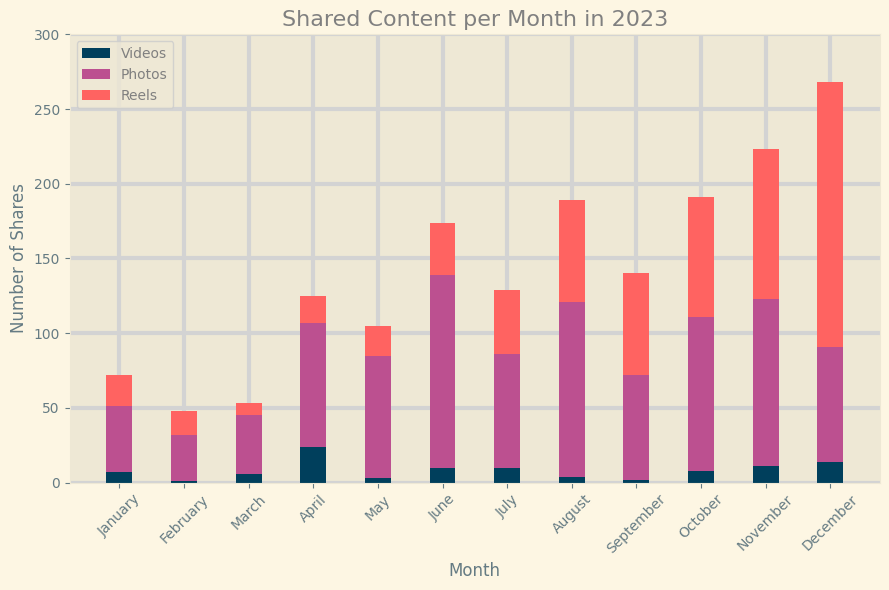

In [137]:
# Resample and count shared content per month
monthly_videos = your_messages['videos'].resample('M').count()
monthly_photos = your_messages['photos'].resample('M').count()
monthly_reels = your_messages[your_messages['share'].astype(str).str.contains('reel')].resample('M').size()

# Calculate the total shared content per month
total_shared_per_month = monthly_videos + monthly_photos + monthly_reels

# Plotting
plt.figure(figsize=(9, 6))

# Get month names for x-axis labels
months = [d.strftime('%B') for d in monthly_videos.index]

# use these colors for the plot bars - #003f5c, #bc5090, #ffa600

# Plot shared content per month
plt.bar(months, monthly_videos, color='#003f5c', label='Videos', width=0.4)
plt.bar(months, monthly_photos, color='#bc5090', label='Photos', width=0.4, bottom=monthly_videos)
plt.bar(months, monthly_reels, color='#ff6361', label='Reels', width=0.4, bottom=monthly_videos + monthly_photos)

plt.title('Shared Content per Month in 2023', color='gray')
plt.xlabel('Month')
plt.ylabel('Number of Shares')
plt.xticks(rotation=45)

# Set y-axis values with 500 intervals
max_content = total_shared_per_month.max()
y_tick_interval = 50
y_ticks = range(0, max_content + y_tick_interval, y_tick_interval)
plt.yticks(y_ticks)

# Change the grid line color
plt.grid(True, color='lightgray', linestyle='-', linewidth=3)

for text in plt.legend().get_texts():
    text.set_color('grey')

plt.grid(True)
plt.tight_layout()
plt.show()

### Shared Content per Month in 2023 - You vs Others

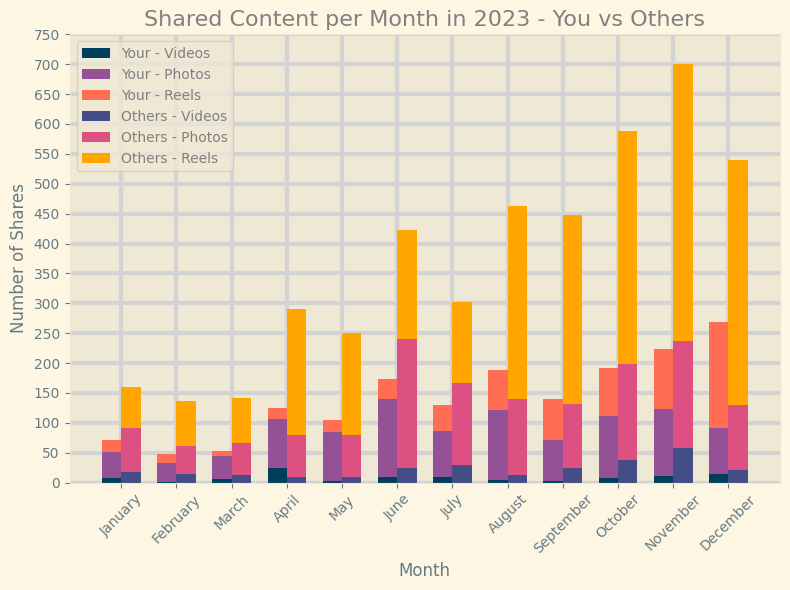

In [138]:
# Function to calculate monthly shared content
def calculate_monthly_shared(df):
    videos = df['videos'].resample('M').count()
    photos = df['photos'].resample('M').count()
    reels = df[df['share'].astype(str).str.contains('reel')].resample('M').size()
    return videos, photos, reels

# Calculate monthly shared content for You and Others
your_videos, your_photos, your_reels = calculate_monthly_shared(your_messages)
other_videos, other_photos, other_reels = calculate_monthly_shared(other_messages)

# Get month names for x-axis labels
months = [d.strftime('%B') for d in your_videos.index]
x = np.arange(len(months))  # the label locations

# Plotting
plt.figure(figsize=(8, 6))

width = 0.35  # the width of the bars

# Define colors
colors = {
    'You': {'Videos': '#003f5c', 'Photos': '#955196', 'Reels': '#ff6e54'},
    'Others': {'Videos': '#444e86', 'Photos': '#dd5182', 'Reels': '#ffa600'}
}

# Plot shared content per month for You
plt.bar(x - width/2, your_videos, width, label='Your - Videos', color=colors['You']['Videos'])
plt.bar(x - width/2, your_photos, width, bottom=your_videos, label='Your - Photos', color=colors['You']['Photos'])
plt.bar(x - width/2, your_reels, width, bottom=your_videos + your_photos, label='Your - Reels', color=colors['You']['Reels'])

# Plot shared content per month for Others
plt.bar(x + width/2, other_videos, width, label='Others - Videos', color=colors['Others']['Videos'])
plt.bar(x + width/2, other_photos, width, bottom=other_videos, label='Others - Photos', color=colors['Others']['Photos'])
plt.bar(x + width/2, other_reels, width, bottom=other_videos + other_photos, label='Others - Reels', color=colors['Others']['Reels'])

plt.title('Shared Content per Month in 2023 - You vs Others', color='gray')
plt.xlabel('Month')
plt.ylabel('Number of Shares')
plt.xticks(x, months, rotation=45)

# Set y-axis values with 500 intervals
max_content = max(your_videos.max() + your_photos.max() + your_reels.max(), 
                  other_videos.max() + other_photos.max() + other_reels.max())
y_tick_interval = 50
y_ticks = range(0, max_content + y_tick_interval, y_tick_interval)
plt.yticks(y_ticks)

# Change the grid line color
plt.grid(True, color='lightgray', linestyle='-', linewidth=3)

for text in plt.legend().get_texts():
    text.set_color('grey')

plt.grid(True)
plt.tight_layout()
plt.show()

### Hourly Messaging Activity Comparison with Day and Night

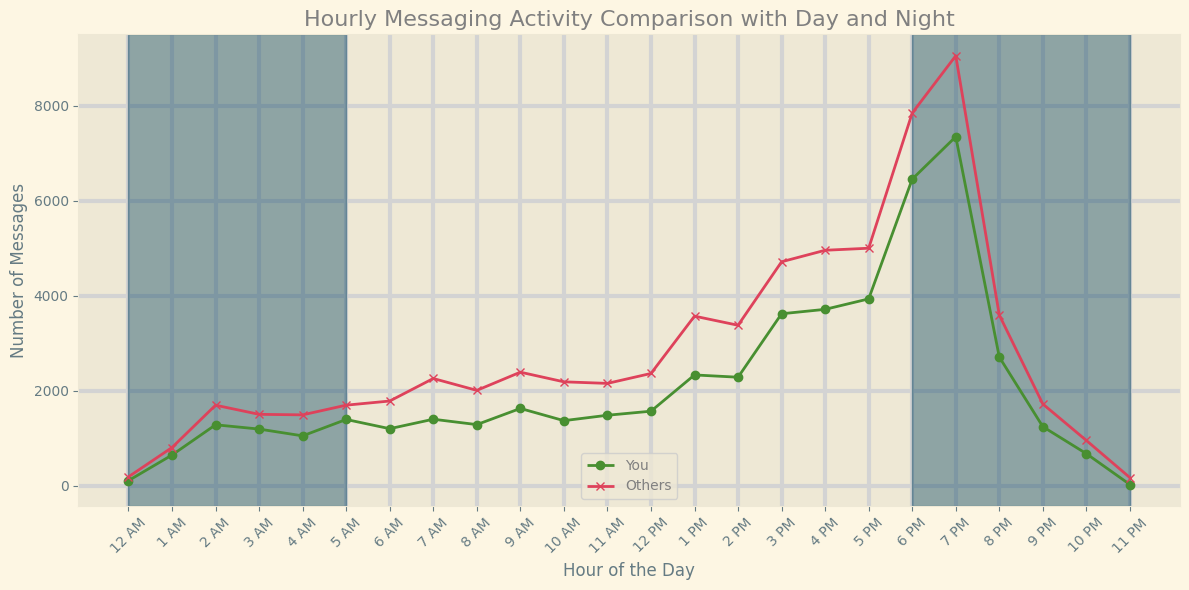

In [191]:
# Separate messages sent by '[your_instagram_name]' and by others
your_messages = messages_2023_df[messages_2023_df['sender_name'] == your_instagram_name]
other_messages = messages_2023_df[messages_2023_df['sender_name'] != your_instagram_name]

# Count messages per hour for You and Others
your_hourly_count = your_messages.groupby('hour').size()
other_hourly_count = other_messages.groupby('hour').size()


# Plotting
plt.figure(figsize=(12, 6))

# Plot data
plt.plot(your_hourly_count, label='You', marker='o', linestyle='-', color='#488f31')
plt.plot(other_hourly_count, label='Others', marker='x', linestyle='-', color='#de425b')

# Shading for night (6 PM to 6 AM)
plt.axvspan(18, 23, color='#003f5c', alpha=0.4)
plt.axvspan(0, 5, color='#003f5c', alpha=0.4)

# Shading for day (6 AM to 6 PM)
# plt.axvspan(5, 18, color='green', alpha=0.2)

# Create AM and PM labels for the x-axis
am_pm_labels = [f'{hour % 12 if hour % 12 != 0 else 12} {"AM" if hour < 12 else "PM"}' for hour in range(24)]

# Change the grid line color
plt.grid(True, color='lightgray', linestyle='-', linewidth=3)

plt.title('Hourly Messaging Activity Comparison with Day and Night', color='gray')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(range(0, 24), am_pm_labels, rotation=45)
for text in plt.legend().get_texts():
    text.set_color('grey')
plt.grid(True)
plt.tight_layout()
plt.show()

## Texting Habits  

### Top 10 Emojis Used

In [140]:
# Function to extract emojis from a text
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

# Extract emojis from 'content' where 'sender_name' is You
your_emojis = all_messages_df[all_messages_df['sender_name'] == your_instagram_name]['content'].dropna().apply(extract_emojis).sum()
your_emoji_counts = Counter(your_emojis)

# Extract emojis from 'reactions' where 'sender_name' is not You
reaction_emojis = all_messages_df[all_messages_df['sender_name'] != your_instagram_name]['reactions'].dropna().apply(extract_emojis).sum()
reaction_emoji_counts = Counter(reaction_emojis)

# Display the top 10 emojis used by You in messages
your_top_emojis = your_emoji_counts.most_common(10)
print("Top 10 Emojis Used by Adam in Messages\n")
your_max_count = your_top_emojis[0][1] if your_top_emojis else 1
your_scale_factor = 50 / your_max_count
for emoji, count in your_top_emojis:
    bar_length = int(count * your_scale_factor)
    bar = '█' * bar_length
    print(f"{emoji} ({count}):\t{bar}")

# Display the top 10 emojis in reactions to others
top_reaction_emojis = reaction_emoji_counts.most_common(10)
print("\nTop 10 Emojis in Reactions to Messages by Others\n")
max_count_reaction = top_reaction_emojis[0][1] if top_reaction_emojis else 1
scale_factor_reaction = 50 / max_count_reaction
for emoji, count in top_reaction_emojis:
    bar_length = int(count * scale_factor_reaction)
    bar = '█' * bar_length
    print(f"{emoji} ({count}):\t{bar}")


Top 10 Emojis Used by Adam in Messages

😭 (5771):	██████████████████████████████████████████████████
🤣 (4912):	██████████████████████████████████████████
💀 (1554):	█████████████
😔 (1373):	███████████
🙄 (1072):	█████████
🥹 (920):	███████
😪 (812):	███████
🥲 (726):	██████
😐 (719):	██████
🥱 (692):	█████

Top 10 Emojis in Reactions to Messages by Others

❤ (6928):	██████████████████████████████████████████████████
💙 (4389):	███████████████████████████████
🌸 (2581):	██████████████████
✨ (562):	████
🔆 (471):	███
🤣 (393):	██
😭 (329):	██
💠 (169):	█
💢 (137):	
🏵 (29):	


### Top Users by Word Count

In [141]:
def display_top_users_by_word_count(df, top_n=10):
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()

    # Ensure 'content' column is string type
    df_copy['content'] = df_copy['content'].astype(str)

    # Count words in each message
    df_copy['word_count'] = df_copy['content'].apply(lambda x: len(x.split()))

    # Aggregate total words by user
    total_words_by_user = df_copy.groupby('sender_name')['word_count'].sum()

    # Get the top N users
    top_users = total_words_by_user.nlargest(top_n)

    # Determine the length of the longest username for alignment
    max_username_length = max(len(user) for user in top_users.index)

    # Display the results with aligned bars
    print(f"Top {top_n} Users by Word Count\n")
    max_count = top_users.iloc[0] if not top_users.empty else 1
    scale_factor = 50 / max_count

    for user, count in top_users.items():
        bar_length = int(count * scale_factor)
        bar = '█' * bar_length
        # Pad the username for alignment
        padded_user = user.ljust(max_username_length)
        print(f"{padded_user} ({count}):\t{bar}")

# Example usage:
# Assuming 'messages_2023_df' is your DataFrame containing the messages
display_top_users_by_word_count(messages_2023_df, top_n=6)  # This will display the top 10 users by word count


Top 6 Users by Word Count

Adam       (298546):	██████████████████████████████████████████████████
𝐬𝐡𝐢𝐤𝐡𝐚     (158460):	██████████████████████████
Eman Mulla (77154):	████████████
Aina ☆     (37277):	██████
W          (23300):	███
Youxxef8   (11916):	█


### Most common words used

In [192]:
def get_most_common_words(data_frame, instagram_user, num_of_top_words=10):
    # Filter rows by sender_name
    your_messages_df = data_frame[data_frame['sender_name'] == instagram_user]

    # Tokenize and count words in the 'content' column
    all_words = ' '.join(your_messages_df['content'].astype(str))
    tokenized_words = word_tokenize(all_words)
    word_counts = Counter(tokenized_words)

    # Display the most common words
    return pd.DataFrame(word_counts.most_common(num_of_top_words), columns=['Word', 'Count'])

# Change 'your_instagram_name' to the instagram name you want to analyze
most_common_words = get_most_common_words(messages_2023_df, your_instagram_name, 20)
pd.DataFrame(most_common_words)

,Word,Count
0,I,16817
1,you,7082
2,the,6632
3,to,6133
4,it,5969
5,a,5725
6,?,5375
7,n't,4418
8,'s,4010
9,that,3779
